## Read molecules from CSV file

In [1]:
import os
import shutil
import subprocess
import time

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
print(rdkit.__version__)
from tqdm import tqdm

from scripts.util import xtb_optimize_geometries

base_path = '/home/slava/rdkit-xtb-geomopt'

2023.09.5


## Embed RDKit Mol objects into 3D space and save XYZ files

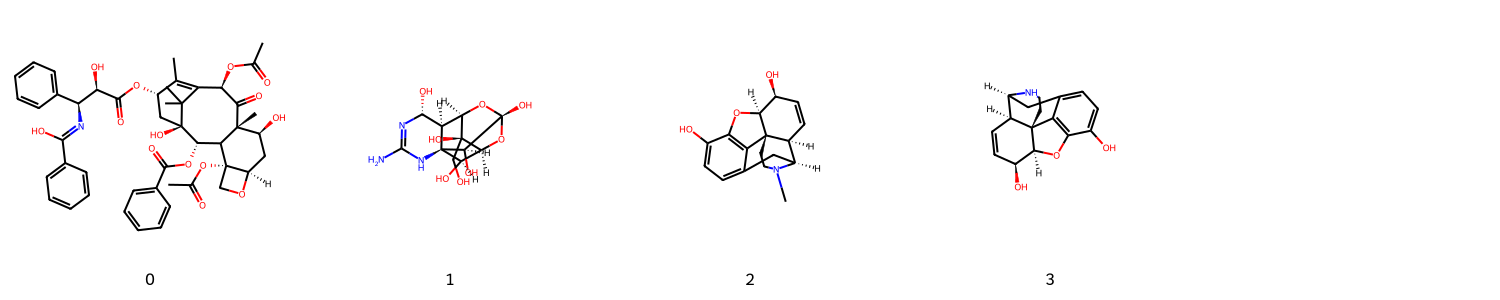

In [2]:
smiles_list = ["CC1=C2[C@H](C(=O)[C@]3(C)[C@H](C[C@@H]4[C@@](CO4)(C3[C@@H]([C@](C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)N=C(C6=CC=CC=C6)O)O)(C2(C)C)O)OC(=O)C7=CC=CC=C7)OC(=O)C)O)OC(=O)C", "C([C@@]1([C@H]2[C@@H]3[C@H](N=C(N)N[C@@]34[C@@H]([C@@H]1O[C@@]([C@H]4O)(O)O2)O)O)O)O", "CN1CC[C@]23[C@H]4C=C[C@@H]([C@@H]2OC5=C3C(=CC=C5O)C[C@@H]41)O", "	C1=C2C[C@H]3[C@@H]4C=C[C@@H]([C@H]5[C@@]4(CCN3)C2=C(C(=C1)O)O5)O"]

mol_list = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    mol.SetProp("_Name", f"{smiles}")
    mol_list.append(mol)

legends = [str(x) for x in range(len(mol_list))]
Draw.MolsToGridImage(mol_list, molsPerRow= 5, subImgSize=(300,300), legends=legends, returnPNG=False)

In [3]:
path_to_xyz = base_path + f'/xyz'
path_to_xtbopt = base_path + f'/xtb'

def clean_directory(directory):
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist. Creating...")
        try:
            os.makedirs(directory)  # Create the directory and any missing parent directories
            print(f"Directory '{directory}' created successfully.")
        except Exception as e:
            print(f"Error creating directory '{directory}': {e}")
        return

    # Check if it's a directory
    if not os.path.isdir(directory):
        print(f"'{directory}' is not a directory.")
        return

    # Get list of files and subdirectories in the directory
    files_and_subdirectories = os.listdir(directory)

    # If the directory is empty, do nothing
    if not files_and_subdirectories:
        print(f"Directory '{directory}' is empty. Nothing to delete.")
        return

    # If the directory is not empty, delete files and subdirectories recursively
    for item in files_and_subdirectories:
        item_path = os.path.join(directory, item)
        try:
            if os.path.isfile(item_path):
                os.remove(item_path)
                print(f"Deleted file: {item}")
            elif os.path.isdir(item_path):
                clean_directory(item_path)  # Recursively delete subdirectories
                os.rmdir(item_path)  # Remove the empty subdirectory
                print(f"Deleted directory: {item_path}")
        except Exception as e:
            print(f"Error deleting {item_path}: {e}")

In [4]:
clean_directory(path_to_xyz)

for i, mol in tqdm(enumerate(mol_list)):
    if mol is None:
        continue
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.MMFFOptimizeMolecule(mol)
    time.sleep(0.05)
    try:
        xyz_content = f"{mol.GetNumAtoms()}\n"

        if mol_list[0].HasProp("_Name"):
            xyz_content += f'{mol.GetProp("_Name")}\n'
        else:
            xyz_content += "\n"
        for atom in mol.GetAtoms():
            pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
            xyz_content += f"{atom.GetSymbol()} {pos.x} {pos.y} {pos.z}\n"


        for atom in mol.GetAtoms():
            pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
            xyz_content += f"{atom.GetSymbol()} {pos.x} {pos.y} {pos.z}\n"
    except:
        continue

    with open(path_to_xyz + f"/xtb_input_{i}.xyz", "w") as xyz_file:
        xyz_file.write(xyz_content)


Deleted file: xtb_input_1.xyz
Deleted file: xtb_input_0.xyz
Deleted file: xtb_input_3.xyz
Deleted file: xtb_input_2.xyz


4it [00:02,  1.56it/s]


## Geometry optimization using xTB-python

In [8]:
xtb_optimize_geometries(path_to_xyz, path_to_xtbopt, opt_lvl='sloppy', silent=True) ## now lets put hyper

['xtb_input_0.xyz', 'xtb_input_1.xyz', 'xtb_input_2.xyz', 'xtb_input_3.xyz']
      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.6.1 (8d0f1dd) compiled by 'conda@1efc2f54142f' on 2023-08-01

   xtb is free software: you can redistribute it and/or modify it under
   the terms of the GNU Lesser General Public License as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
   
   xtb is d

normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


   1    -74.0607519 -0.740608E+02  0.439E+00    5.06       0.0  T
   2    -74.1363769 -0.756250E-01  0.243E+00    5.09       1.0  T
   3    -74.1381252 -0.174825E-02  0.890E-01    5.02       1.0  T
   4    -74.1425165 -0.439137E-02  0.176E-01    4.97       1.0  T
   5    -74.1428212 -0.304632E-03  0.755E-02    5.02       1.0  T
   6    -74.1428639 -0.426996E-04  0.320E-02    5.01       1.0  T
   7    -74.1428675 -0.367621E-05  0.131E-02    5.02       1.2  T
   8    -74.1428696 -0.206286E-05  0.403E-03    5.01       4.0  T
   9    -74.1428697 -0.745323E-07  0.146E-03    5.01      10.9  T
  10    -74.1428697 -0.124283E-07  0.570E-04    5.01      28.1  T
  11    -74.1428697 -0.242510E-08  0.192E-04    5.01      83.2  T

   *** convergence criteria satisfied after 11 iterations ***

         #    Occupation            Energy/Eh            Energy/eV
      -------------------------------------------------------------
         1        2.0000           -0.7407962             -20.1581
       .

normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL



           -------------------------------------------------
          |                 G F N 2 - x T B                 |
           -------------------------------------------------

        Reference                      10.1021/acs.jctc.8b01176
      * Hamiltonian:
        H0-scaling (s, p, d)           1.850000    2.230000    2.230000
        zeta-weighting                 0.500000
      * Dispersion:
        s8                             2.700000
        a1                             0.520000
        a2                             5.000000
        s9                             5.000000
      * Repulsion:
        kExp                           1.500000    1.000000
        rExp                           1.000000
      * Coulomb:
        alpha                          2.000000
        third order                    shell-resolved
        anisotropic                    true
        a3                             3.000000
        a5                             4.000000
        cn-

normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


    1    6 C      1-12, 14-17
    2    7 N      13
    3    8 O      18-20
    4    1 H      21-37
########################################################################
[WARNING] Please study the warnings concerning your input carefully
-1- prog_main_parseArguments: Unknown option '--silent' provided
########################################################################

           -------------------------------------------------
          |                 G F N 2 - x T B                 |
           -------------------------------------------------

        Reference                      10.1021/acs.jctc.8b01176
      * Hamiltonian:
        H0-scaling (s, p, d)           1.850000    2.230000    2.230000
        zeta-weighting                 0.500000
      * Dispersion:
        s8                             2.700000
        a1                             0.520000
        a2                             5.000000
        s9                             5.000000
      * Repulsion:


normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
